In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import matplotlib as mpl
from matplotlib import pyplot as plt, cm
from matplotlib import colors

plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#    'mathtext.fontset': 'custom',
#    'mathtext.rm': 'Bitstream Vera Sans',
#    'mathtext.it': 'Bitstream Vera Sans:italic',
#    'mathtext.bf': 'Bitstream Vera Sans:bold',   
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
})

from common import dalt
from common import hallmark as hm
from common import mockservation as mk
from common import viz
from common import io_ipole as io


In [3]:
pf = hm.ParaFrame('cache/SPO/gt/{NGC}_a{aspin:g}_i{inc:g}_{freq}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

aspin [-0.94 -0.5   0.    0.5   0.94]
freq ['230.e9']
NGC ['SgrA']
inc [30.]


In [8]:
def load(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    return dalt.Image(data, meta=meta)

def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)


def vizrow(plot, ylim=None, ylabel=None):
    fig, axes = plt.subplots(5, figsize=(10,15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    for a, ax in enumerate(axes):
        sel = pf(aspin=aspin[a])
        ax = axes[a]
        ax.set_title(f'$a_\mathrm{{spin}}$={aspin[a]}')
        plot(ax, sel)

        if ylim != None:
            ax.set_ylim(ylim[0], ylim[1])

        ax.tick_params(
            axis='both',
            direction='in',
            top=True,
            right=True,
            color='w',
        )
        for spine in ax.spines.values():
            spine.set_edgecolor('w')

    
    if ylabel != None:
        axes[0].set_ylabel(ylabel)
    plt.tight_layout()

In [5]:
def plva(name):

    mov = readimg(name)
    vis = mk.mockserve(mov, N=512)

    U, V = vis.uvd
    uu = np.linspace( 0,   U/2, num=vis.shape[-1])
    vv = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t  = vis.meta.time.value

    amp = RegularGridInterpolator((t, vv, uu[::-1]), abs     (vis[...,::-1]))
    uvd = np.linspace(0, 1.1e10, round(1e10/1e8)+1)
    
    va = []
    for t0 in tqdm(t):
        s_all = []
        for i in range(-90,90,45):
            phi = np.pi * i / 180
            uu  = uvd * np.cos(phi)
            vv  = uvd * np.sin(phi)

            mask = (uu <= 0)
            p = np.array([np.repeat(t0, np.sum( mask)),  vv[ mask],  uu[ mask]]).T
            m = np.array([np.repeat(t0, np.sum(~mask)), -vv[~mask], -uu[~mask]]).T
    
            s = np.zeros(len(uvd))
            s[ mask] = amp(p)
            s[~mask] = amp(m)
        
            s_all.append(s/s[0])
        va.append(s_all)
            
    return uvd, np.array(va)

In [ ]:
def plot_curve(ax, pf):
    uvd, va = plva(pf.path.iloc[0])

    frame = -9

    nmin = 2.5e9
    nmax = 3.5e9

    bmin = 6e9
    bmax = 8e9

    ax.axvspan(nmin/1e9, nmax/1e9, color='k', alpha=1/10, edgecolor=None)
    ax.fill_between([bmin/1e9, bmax/1e9], 0.04/0.5, color='k', alpha=1/10)
    lc = [argrelextrema(va[frame,i,:], np.less)[0] for i in range(4)]
    for i, PA in enumerate(range(-90,90,45)):
        p = ax.plot(uvd/1e9, va[frame,i,:], label=f'$\mathrm{{PA}}={PA}\degree$')
        if len(lc[i]) > 0:
            ax.scatter(uvd[lc[i][0]]/1e9, va[frame,i,lc[i][0]], color=p[0].get_color())
        la = np.median(va[frame,i,(bmin <= uvd) & (uvd <= bmax)])
        ax.plot([bmin/1e9, bmax/1e9], [la, la], ':', color=p[0].get_color())
    ax.set_yscale('log')
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(0.1/12, 0.1*12)
    ax.set_xlabel('$(u, v)$ distance [G$\lambda$]')
    ax.set_ylabel('$230\,\mathrm{GHz}$ normalized visibility amplitude $|V/V_0|$')
    ax.tick_params(
        which='both',
        axis='both',
        direction='in',
        top=True,
        right=True)

100%|██████████| 1000/1000 [00:00<00:00, 1526.81it/s]


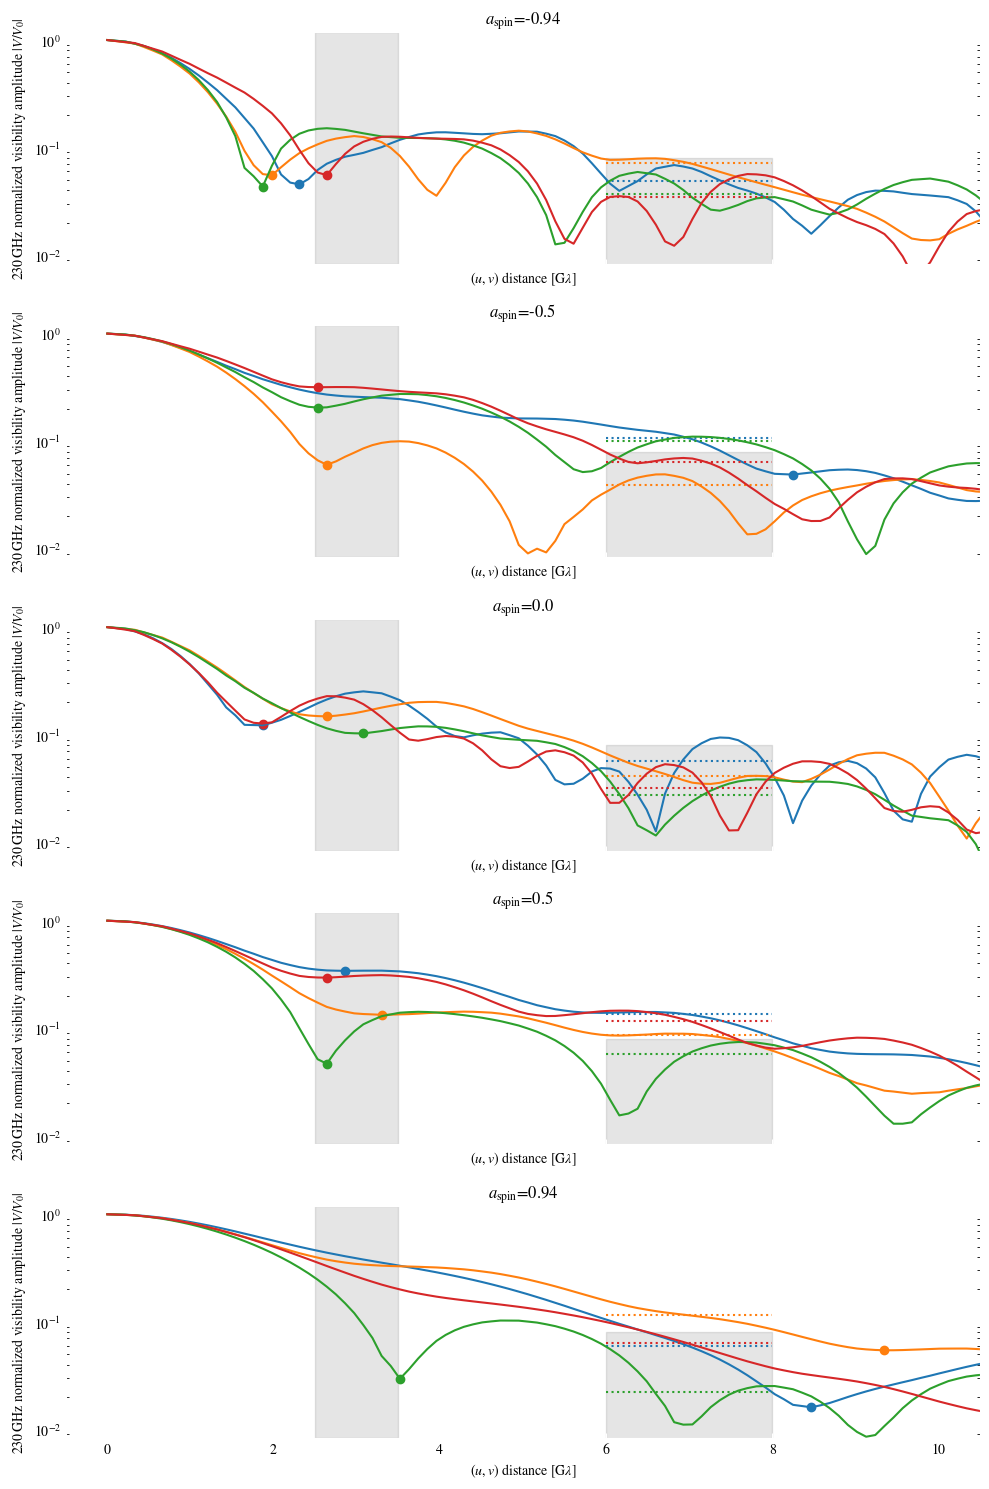

In [9]:
vizrow(plot_curve)